In [1]:
using Revise
using FLOYao
using Yao
using SkewLinearAlgebra
using Tullio
using FiniteDifferences
using Symbolics
using SymbolicUtils

[ Info: Precompiling FLOYao [6d9310a3-f1d0-41b7-8edb-11c1cf57cd2d] (cache misses: include_dependency fsize change (2), dep missing source (2), invalid header (2), mismatched flags (6))


LoadError: ArgumentError: Package Tullio not found in current path.
- Run `import Pkg; Pkg.add("Tullio")` to install the Tullio package.

In [144]:
using Symbolics
using PrettyChairmarks
using ProfileSVG
# using SymPy

In [224]:
using LinearAlgebra
⊗ = kron

kron (generic function with 72 methods)

In [225]:
using Revise

In [226]:
function matdisplay(mat, digits=2)
    display(round.(mat, digits=digits))
end

matdisplay (generic function with 2 methods)

In [227]:
reg1 = FLOYao.rand_state(400)
reg2 = FLOYao.zero_state(400)
fidelity(reg1, reg2)

1.710108214099236e-45

In [228]:
@bs fidelity(reg1, reg2)

Chairmarks.Benchmark: 1 sample with 1 evaluation.
 Single result which took 327.126 ms (2.01% GC) to evaluate,
 with a memory estimate of 14.72 MiB, over 2329 allocations.

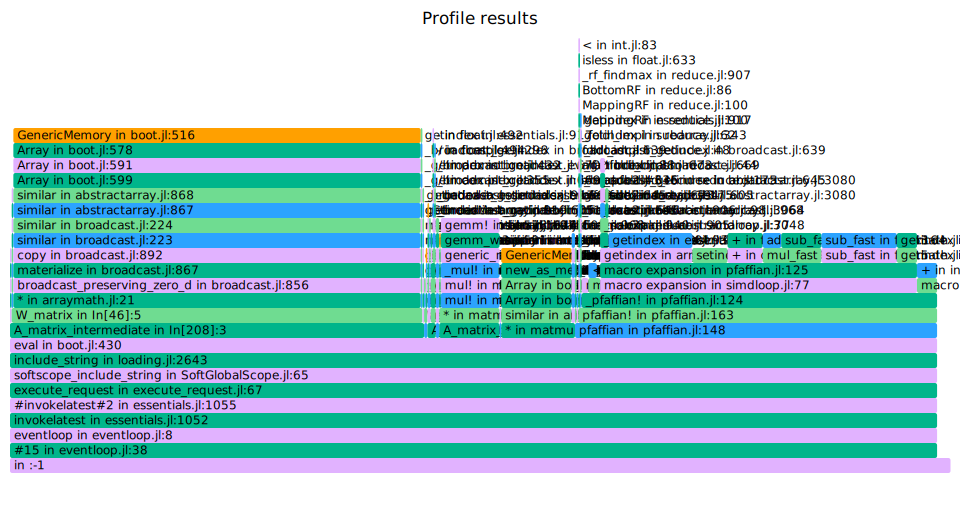

In [229]:
@profview pfaffian(A_matrix_intermediate(reg1.state' * reg2.state))

In [230]:
c1 = chain(2, rot(kron(2, 1=>X, 2=>X), 0.1), put(1 => Rz(0.5)))

nqubits: 2
chain
├─ rot(nqubits: 2
kron
├─ 1=>X
└─ 2=>X, 0.1)
└─ put on (1)
   └─ rot(Z, 0.5)


In [231]:
fidelity(reg1, reg2 => c1)

LoadError: register size 400 mismatch with block size 2

In [63]:
in1δ, in2δ = Yao.AD.fidelity_g(reg1, reg2 => c1)

(MajoranaReg{Float64}(2), MajoranaReg{Float64}(2) => [0.0, 0.0])

In [64]:
areg1 = FLOYao.majorana2arrayreg(reg1)
areg2 = FLOYao.majorana2arrayreg(reg2)
in1δ, in2δ = Yao.AD.fidelity_g(areg1, areg2 => c1)

(ArrayReg{2, ComplexF64, Array...}
    active qubits: 2/2
    nlevel: 2, ArrayReg{2, ComplexF64, Array...}
    active qubits: 2/2
    nlevel: 2 => Any[-1.313537584359156e-16, 7.199904224175629e-18])

In [232]:
0.23665 / 0.29262

0.8087280431959538

In [233]:
function W_matrix(R::Matrix{T}) where {T}
    n = size(R, 1) ÷ 2
    W = zeros(Complex{T}, 2n, 2n)
    for i in 1:2:2n
        W[:,i] .= R[:,i] .- 1im * R[:,i+1]
        W[:,i+1] .= R[:,i] .+ 1im * R[:,i+1]
    end
    return W
end

W_matrix (generic function with 1 method)

In [234]:
function W_matrix_tullio(R::Matrix{T}) where {T}
    n = size(R, 1) ÷ 2
    R = reshape(R, 2, n, 2, n)
    W = zeros(Complex{T}, 2, n, 2, n)
    @tullio W[μ,m,α,i] = R[μ,m,1,i] + 1im*(-1)^α * R[μ,m,2,i]
    return reshape(W, 2n, 2n)
end

W_matrix_tullio (generic function with 1 method)

In [235]:
@bs W_matrix(reg1.state)

Chairmarks.Benchmark: 18 samples with 1 evaluation.
 Range (min … max):  4.997 ms … 9.712 ms  ┊ GC (min … max): 30.59% … 63.07%
 Time  (median):     5.376 ms             ┊ GC (median):    32.08%
 Time  (mean ± σ):   5.588 ms ± 1.054 ms  ┊ GC (mean ± σ):  33.67% ±  7.37%

  █▃ ▃█ ▃█                                                   
  ██▇██▁██▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  5 ms           Histogram: frequency by time       9.71 ms <

 Memory estimate: 29.44 MiB, allocs estimate: 7207.

In [236]:
matdisplay(W_matrix_tullio(reg1.state))

800×800 Matrix{ComplexF64}:
 -0.01+0.01im  -0.01-0.01im   0.02-0.02im  …  -0.01-0.02im  -0.01+0.02im
  0.04+0.01im   0.04-0.01im   0.02+0.03im      -0.0-0.0im    -0.0+0.0im
   0.0-0.01im    0.0+0.01im   0.02-0.0im       -0.0-0.0im    -0.0+0.0im
  0.08-0.03im   0.08+0.03im   0.02+0.01im      -0.0-0.0im    -0.0+0.0im
 -0.04+0.11im  -0.04-0.11im   0.01+0.03im      -0.0-0.0im    -0.0+0.0im
  0.02+0.03im   0.02-0.03im   0.01+0.04im  …   -0.0+0.0im    -0.0-0.0im
 -0.01-0.09im  -0.01+0.09im   0.04-0.03im      -0.0-0.0im    -0.0+0.0im
  0.03-0.07im   0.03+0.07im  -0.11+0.05im      -0.0+0.0im    -0.0-0.0im
  0.05+0.06im   0.05-0.06im   0.02+0.07im      0.01+0.0im    0.01-0.0im
  0.08-0.05im   0.08+0.05im  -0.01+0.03im       0.0+0.0im     0.0-0.0im
  0.04-0.04im   0.04+0.04im  -0.06-0.07im  …  -0.01-0.0im   -0.01+0.0im
 -0.02-0.0im   -0.02+0.0im   -0.04+0.03im       0.0+0.0im     0.0-0.0im
  0.05-0.01im   0.05+0.01im  -0.06+0.04im       0.0+0.0im     0.0-0.0im
      ⋮                            

In [237]:
function A_matrix(reg::MajoranaReg{T}) where {T}
    n = nqubits(reg)
    R = reg.state
    W = W_matrix(R)
    # matdisplay(W)

    # Pretty sure this could be sped up with some explicit for loops
    A = transpose(W) * (I(n) ⊗ [1 -1im; 1im 1]) * W / 4
    #A_sym = transpose(W) * W / 4
    # matdisplay(A_sym)
    #A_asym = transpose(W) * (I(n) ⊗ [0 -1im; 1im 0]) * W / 4
    # matdisplay(A_asym)
    
    #A = A_sym + A_asym

    # Take the _correct_ anti-symmetric part of it!
    for i in 1:2n
        for j in i+1:2n
            A[j,i] = -A[i,j]
        end
    end
    A[diagind(A)] .= 0
    return A
end

A_matrix (generic function with 1 method)

In [238]:
function A_matrix_intermediate(R)
    n = size(R, 1) ÷ 2
    W = W_matrix(R)

    gW = zero(W)
    for i in 1:2:2n
        gW[i,:] .= (W[i,:] .- 1im .* W[i+1,:]) ./ 4
        gW[i+1,:] .= (1im .* W[i,:] .+ W[i+1,:]) ./ 4
    end

    A = transpose(W) * gW
    # take the correct anti-symmetric part
    for i in 1:2n
        for j in i+1:2n
            A[j,i] = -A[i,j]
        end
    end
    A[diagind(A)] .= 0

    return A
end

A_matrix_intermediate (generic function with 1 method)

In [239]:
# a neat operator do take an inner product w/o complex conjugation
⊙(a, b) = transpose(a) * b

function A_matrix_manual(reg::MajoranaReg{T}) where {T}
    n = 2nqubits(reg)
    R = reg.state
    W = W_matrix(R)

    A = zero(W)
    for j in 1:n, i in 1:j-1
        val = @views (W[1:2:n,i] ⊙ W[1:2:n,j] + 1im * W[2:2:n,i] ⊙ W[1:2:n,j] 
                      - 1im * W[1:2:n,i] ⊙ W[2:2:n,j] + W[2:2:n,i] ⊙ W[2:2:n,j]) / 4
        A[i,j] = val
        A[j,i] = -val
    end
    return A
end

A_matrix_manual (generic function with 1 method)

In [240]:
A_matrix(reg1) - A_matrix_manual(reg1) |> norm

1.8222158904579628e-14

In [241]:
@bs A_matrix(reg1)

Chairmarks.Benchmark: 2 samples with 1 evaluation.
 Range (min … max):  74.978 ms … 80.160 ms  ┊ GC (min … max): 0.00% … 10.28%
 Time  (median):     77.569 ms              ┊ GC (median):    5.14%
 Time  (mean ± σ):   77.569 ms ±  3.664 ms  ┊ GC (mean ± σ):  5.14% ±  7.27%

  █                                                         █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  75 ms           Histogram: frequency by time        80.2 ms <

 Memory estimate: 85.34 MiB, allocs estimate: 1108268.

In [242]:
@bs A_matrix_intermediate(reg1)

LoadError: MethodError: no method matching size(::MajoranaReg{Float64}, ::Int64)
The function `size` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  size([91m::BitVector[39m, ::Integer)
[0m[90m   @[39m [90mBase[39m [90m[4mbitarray.jl:107[24m[39m
[0m  size([91m::Luxor.Table[39m, ::Int64)
[0m[90m   @[39m [35mLuxor[39m [90m~/.julia/packages/Luxor/0kqwd/src/[39m[90m[4mTable.jl:227[24m[39m
[0m  size([91m::Type{<:Diagonal{T, StaticArraysCore.SVector{N, T}} where T}[39m, ::Int64) where N
[0m[90m   @[39m [33mStaticArrays[39m [90m~/.julia/packages/StaticArrays/9Yt0H/src/[39m[90m[4mSDiagonal.jl:18[24m[39m
[0m  ...


In [196]:
@bs A_matrix_manual(reg1)

Chairmarks.Benchmark: 1 sample with 1 evaluation.
 Single result which took 1.234 s (18.20% GC) to evaluate,
 with a memory estimate of 3.89 GiB, over 1924810 allocations.

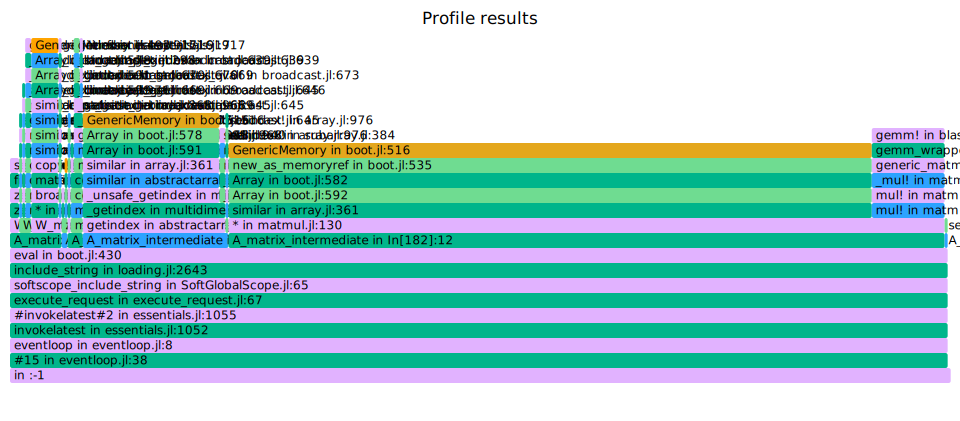

In [193]:
@profview A_matrix_intermediate(reg1)

In [228]:
function fidelity_observable_matrix(R)
    n = size(R, 1) ÷ 2
    W = W_matrix(R)
    # matdisplay(W)

    # Pretty sure this could be sped up with some explicit for loops
    # A = transpose(W) * (I(n) ⊗ [1 -1im; 1im 1]) * W / 4
    A_sym = transpose(W) * W / 4
    # matdisplay(A_sym)
    A_asym = transpose(W) * (I(n) ⊗ [0 -1im; 1im 0]) * W / 4
    # matdisplay(A_asym)
    
    A = A_sym + A_asym

    # Take the _correct_ anti-symmetric part of it!
    for i in 1:2n
        for j in i+1:2n
            A[j,i] = -A[i,j]
        end
    end
    A[diagind(A)] .= 0
    return A
end

fidelity_observable_matrix (generic function with 2 methods)

In [243]:
function fidelity_observable_matrix_tullio(reg::MajoranaReg{T}) where {T}
    n = nqubits(reg)
    g = [0 -1im; 1im 0]

    W = reshape(W_matrix_tullio(reg.state), 2, n, 2, n)
    # matdisplay(reshape(W, 2n, 2n))

    @tullio A_sym[α,i,β,j] := W[μ,m,α,i] * W[μ,m,β,j] / 4
    # matdisplay(reshape(A_sym, 2n, 2n))
    @tullio A_asym[α,i,β,j] := W[μ,m,α,i] * g[μ, ν] * W[ν,m,β,j] / 4
    # matdisplay(reshape(A_asym, 2n, 2n))
    @tullio A[α,i,β,j] := A_sym[α,i,β,j] + A_asym[α,i,β,j]
    
    A = reshape(A, 2n, 2n)
    for i in 1:2n
        for j in i+1:2n
            A[j,i] = -A[i,j]
        end
    end
    A[diagind(A)] .= 0
    return A
end

fidelity_observable_matrix_tullio (generic function with 1 method)

In [244]:
A = A_matrix(reg1)
# W = simplify.(W; expand=true)
# A = simplify.(A; expand=true)
matdisplay(A)

800×800 Matrix{ComplexF64}:
   0.0+0.0im    0.54+0.0im   …  -0.0-0.0im   0.0-0.0im   0.0+0.0im
 -0.54-0.0im     0.0+0.0im      -0.0-0.0im  -0.0+0.0im  -0.0-0.0im
 -0.01-0.0im    0.01+0.0im       0.0-0.0im  -0.0-0.0im   0.0+0.0im
 -0.01+0.0im    0.01-0.0im       0.0+0.0im  -0.0+0.0im   0.0-0.0im
 -0.02+0.01im   0.02+0.0im       0.0+0.0im  -0.0-0.0im  -0.0+0.0im
 -0.02+0.0im    0.02+0.01im  …  -0.0-0.0im   0.0+0.0im   0.0-0.0im
  0.01-0.0im    0.01-0.01im     -0.0+0.0im  -0.0+0.0im  -0.0+0.0im
 -0.01-0.01im  -0.01-0.0im      -0.0+0.0im   0.0+0.0im   0.0+0.0im
 -0.01+0.01im   0.02-0.01im      0.0-0.0im   0.0-0.0im   0.0+0.0im
 -0.02-0.01im   0.01+0.01im      0.0-0.0im  -0.0+0.0im  -0.0-0.0im
  0.01-0.01im  -0.01-0.02im  …  -0.0-0.0im  -0.0-0.0im  -0.0-0.0im
  0.01-0.02im  -0.01-0.01im     -0.0-0.0im   0.0-0.0im   0.0-0.0im
 -0.02-0.01im  -0.01-0.01im     -0.0+0.0im  -0.0+0.0im  -0.0+0.0im
      ⋮                      ⋱                          
  -0.0-0.0im    -0.0+0.0im      -0.0-0.0im  

In [245]:
A = fidelity_observable_matrix_tullio(reg1)
matdisplay(A)

800×800 Matrix{ComplexF64}:
   0.0+0.0im    0.54-0.0im   …  -0.0-0.0im   0.0-0.0im   0.0+0.0im
 -0.54+0.0im     0.0+0.0im      -0.0-0.0im  -0.0+0.0im  -0.0-0.0im
 -0.01-0.0im    0.01+0.0im       0.0-0.0im  -0.0-0.0im   0.0+0.0im
 -0.01+0.0im    0.01-0.0im       0.0+0.0im  -0.0+0.0im   0.0-0.0im
 -0.02+0.01im   0.02+0.0im       0.0+0.0im  -0.0-0.0im  -0.0+0.0im
 -0.02+0.0im    0.02+0.01im  …  -0.0-0.0im   0.0+0.0im   0.0-0.0im
  0.01-0.0im    0.01-0.01im     -0.0+0.0im  -0.0+0.0im  -0.0+0.0im
 -0.01-0.01im  -0.01-0.0im      -0.0+0.0im   0.0+0.0im   0.0+0.0im
 -0.01+0.01im   0.02-0.01im      0.0-0.0im   0.0-0.0im   0.0+0.0im
 -0.02-0.01im   0.01+0.01im      0.0-0.0im  -0.0+0.0im  -0.0-0.0im
  0.01-0.01im  -0.01-0.02im  …  -0.0-0.0im  -0.0-0.0im  -0.0-0.0im
  0.01-0.02im  -0.01-0.01im     -0.0-0.0im   0.0-0.0im   0.0-0.0im
 -0.02-0.01im  -0.01-0.01im     -0.0+0.0im  -0.0+0.0im  -0.0+0.0im
      ⋮                      ⋱                          
  -0.0-0.0im    -0.0+0.0im      -0.0-0.0im  

In [246]:
function B_matrix(A_inv)
    n = size(A_inv, 1) ÷ 2
    B = zero(A_inv)
    for i in 1:2:2n
        B[:,i] .= A_inv[:,i] .+ A_inv[:,i+1]
        B[:,i+1] .= -1im .* A_inv[:,i] .+ 1im .* A_inv[:,i+1]
    end
    return B
end

B_matrix (generic function with 1 method)

In [247]:
function B_matrix_tullio(A_inv)
    n = size(A_inv, 1) ÷ 2
    A_inv = reshape(A_inv, 2, n, 2, n)
    δ = Matrix(I(2))
    @tullio B[β,j,γ,g] := A_inv[β,j,1,g] * (δ[γ,1] - 1im * δ[γ,2])  + A_inv[β,j,2,g] * (δ[γ,1] + 1im * δ[γ,2])
    return reshape(B, 2n, 2n)
end

B_matrix_tullio (generic function with 1 method)

In [255]:
A = fidelity_observable_matrix(reg1)
det(A)

LoadError: UndefVarError: `fidelity_observable_matrix` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [235]:
A_inv = inv(A)
matdisplay(A_inv)

4×4 Matrix{ComplexF64}:
 -0.0-0.0im    -1.0+0.0im   -1.87-0.19im  -0.0-0.0im
  1.0-0.0im     0.0-0.0im     0.0-0.0im   1.87-0.19im
 1.87+0.19im   -0.0+0.0im     0.0-0.0im   -1.0+0.0im
  0.0+0.0im   -1.87+0.19im    1.0-0.0im    0.0+0.0im

In [236]:
B = B_matrix(A_inv)
matdisplay(B)

4×4 Matrix{ComplexF64}:
  -1.0+0.0im    -0.0-1.0im   -1.87-0.19im  -0.19+1.87im
   1.0-0.0im    -0.0-1.0im    1.87-0.19im   0.19+1.87im
  1.87+0.19im   0.19-1.87im   -1.0+0.0im    -0.0-1.0im
 -1.87+0.19im  -0.19-1.87im    1.0-0.0im    -0.0-1.0im

In [237]:
B = B_matrix_tullio(A_inv)
matdisplay(B)

4×4 Matrix{ComplexF64}:
  -1.0+0.0im    -0.0-1.0im   -1.87-0.19im  -0.19+1.87im
   1.0-0.0im    -0.0-1.0im    1.87-0.19im   0.19+1.87im
  1.87+0.19im   0.19-1.87im   -1.0+0.0im    -0.0-1.0im
 -1.87+0.19im  -0.19-1.87im    1.0-0.0im    -0.0-1.0im

In [254]:
function C_matrix(W)
    n = size(W, 1) ÷ 2
    C = zero(W)
    for i in 1:2:2n
        C[:,i] .= -W[i+1,:] 
        C[:,i+1] .= W[i,:] 
    end
    return C
end

C_matrix (generic function with 1 method)

In [239]:
function C_matrix_tullio(W)
    n = size(W, 1) ÷ 2
    W = reshape(W, 2, n, 2, n)
    g = [0 -1; 1 0]
    ii = Matrix(I(n))
    @tullio C[β,j,δ,d] := W[μ,m,β,j] * ii[d,m] * g[δ,μ]
    return reshape(C, 2n, 2n)
end

C_matrix_tullio (generic function with 1 method)

In [240]:
W = W_matrix(reg1.state)
matdisplay(W)

4×4 Matrix{ComplexF64}:
  0.6+0.53im   0.6-0.53im  -0.14-0.58im  -0.14+0.58im
  0.2+0.4im    0.2-0.4im    0.81+0.38im   0.81-0.38im
 0.72-0.67im  0.72+0.67im    0.1+0.12im    0.1-0.12im
 0.26+0.33im  0.26-0.33im  -0.56+0.71im  -0.56-0.71im

In [253]:
C = C_matrix(W)
matdisplay(C)

LoadError: UndefVarError: `C_matrix` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [242]:
C = C_matrix_tullio(W)
matdisplay(C)

4×4 Matrix{ComplexF64}:
  -0.2-0.4im     0.6+0.53im  -0.26-0.33im  0.72-0.67im
  -0.2+0.4im     0.6-0.53im  -0.26+0.33im  0.72+0.67im
 -0.81-0.38im  -0.14-0.58im   0.56-0.71im   0.1+0.12im
 -0.81+0.38im  -0.14+0.58im   0.56+0.71im   0.1-0.12im

In [243]:
function C_tilde_matrix(W)
    return transpose(W)
end

C_tilde_matrix (generic function with 1 method)

In [244]:
function C_tilde_matrix_tullio(W)
    n = size(W, 1) ÷ 2
    W = reshape(W, 2, n, 2, n)
    @tullio C_tilde[β,j,δ,d] := W[δ,d,β,j]
    return reshape(C_tilde, 2n, 2n)
end

C_tilde_matrix_tullio (generic function with 1 method)

In [245]:
C = C_tilde_matrix(W)
matdisplay(C)

4×4 Matrix{ComplexF64}:
   0.6+0.53im   0.2+0.4im   0.72-0.67im   0.26+0.33im
   0.6-0.53im   0.2-0.4im   0.72+0.67im   0.26-0.33im
 -0.14-0.58im  0.81+0.38im   0.1+0.12im  -0.56+0.71im
 -0.14+0.58im  0.81-0.38im   0.1-0.12im  -0.56-0.71im

In [246]:
C = C_tilde_matrix_tullio(W)
matdisplay(C)

4×4 Matrix{ComplexF64}:
   0.6+0.53im   0.2+0.4im   0.72-0.67im   0.26+0.33im
   0.6-0.53im   0.2-0.4im   0.72+0.67im   0.26-0.33im
 -0.14-0.58im  0.81+0.38im   0.1+0.12im  -0.56+0.71im
 -0.14+0.58im  0.81-0.38im   0.1-0.12im  -0.56-0.71im

In [247]:
function B_tilde_matrix(A_inv)
    n = size(A_inv, 1) ÷ 2
    B_tilde = zero(A_inv)
    for g in 1:2:2n, j in 1:2:2n
        if j < g
            B_tilde[j,g] = -A_inv[j,g] + 1im * A_inv[j,g+1]
            B_tilde[j+1,g] = 1im * A_inv[j+1,g] - A_inv[j+1,g+1]
            B_tilde[j,g+1] = 1im * A_inv[j,g] + A_inv[j,g+1]
            B_tilde[j+1,g+1] = -A_inv[j+1,g] - 1im * A_inv[j+1,g+1]
        elseif j > g
            B_tilde[j,g] = A_inv[j,g] - 1im * A_inv[j,g+1]
            B_tilde[j+1,g] = -1im * A_inv[j+1,g] + A_inv[j+1,g+1]
            B_tilde[j,g+1] = -1im * A_inv[j,g] - A_inv[j,g+1]
            B_tilde[j+1,g+1] = A_inv[j+1,g] + 1im * A_inv[j+1,g+1]
        else # j == g #  
            B_tilde[j,g] = -A_inv[j,g+1]
            B_tilde[j+1,g] = A_inv[j+1,g]
            B_tilde[j,g+1] = -1im * A_inv[j,g+1]
            B_tilde[j+1,g+1] = -1im * A_inv[j+1,g]
        end
    end
    return B_tilde
end

B_tilde_matrix (generic function with 1 method)

In [343]:
function B_tilde_matrix_tullio(A_inv)
    n = size(A_inv, 1) ÷ 2
    # A_inv = reshape(A_inv, 2, n, 2, n)
    δ = Matrix(I(2))
    Δ = Matrix(I(n))
    @tullio D[γ,g,α,i] := Δ[g,i] * (δ[γ,1] + 1im * (-1)^α * δ[γ,2]) (α in 1:2)
    # matdisplay(reshape(D, 2n, 2n))
    D = reshape(D, 2n, 2n)
    # i = iα, j = jβ, g = gγ
    B = zero(A_inv)
    for g in 1:2n, j in 1:2n
        for i in 1:j-1
            B[j,g] -= A_inv[i,j] * D[g,i]
        end
        for i in j+1:2n
            B[j,g] += A_inv[i,j] * D[g,i]
        end
    end
    return B
end

B_tilde_matrix_tullio (generic function with 1 method)

In [344]:
A_inv |> matdisplay

4×4 Matrix{ComplexF64}:
   0.0+0.0im   -1.0+0.0im   0.57+1.02im    0.0-0.0im
   1.0-0.0im   -0.0+0.0im   -0.0+0.0im   -0.57+1.02im
 -0.57-1.02im   0.0-0.0im    0.0+0.0im    -1.0+0.0im
  -0.0+0.0im   0.57-1.02im   1.0-0.0im     0.0+0.0im

In [345]:
B_tilde = B_tilde_matrix(A_inv)
matdisplay(B_tilde)

4×4 Matrix{ComplexF64}:
   1.0-0.0im     0.0+1.0im   -0.57-1.02im  -1.02+0.57im
   1.0-0.0im    -0.0-1.0im    0.57-1.02im   1.02+0.57im
 -0.57-1.02im  -1.02+0.57im    1.0-0.0im     0.0+1.0im
  0.57-1.02im   1.02+0.57im    1.0-0.0im    -0.0-1.0im

In [346]:
B_tilde = B_tilde_matrix_tullio(A_inv)
matdisplay(B_tilde)

4×4 Matrix{ComplexF64}:
   1.0-0.0im     0.0+1.0im   -0.57-1.02im  -1.02+0.57im
   1.0-0.0im    -0.0-1.0im    0.57-1.02im   1.02+0.57im
 -0.57-1.02im  -1.02+0.57im    1.0-0.0im     0.0+1.0im
  0.57-1.02im   1.02+0.57im    1.0+0.0im     0.0-1.0im

In [222]:
function fidelity_gradient(R)
    n = size(R, 1) ÷ 2
    W = W_matrix(R)
    
    # Todo: Reuse W here!
    A = A_matrix_intermediate(R)
    val = pfaffian(A)
    A_inv = inv(A)
    
    B = B_matrix(A_inv)
    C = C_matrix(W)
    B_tilde = B_tilde_matrix(A_inv)
    C_tilde = C_tilde_matrix(W)
    
    # The real part of this is correct. But where is the imaginary part from?
    #             purely real             not purely real, a bug?
    return val * (1im * transpose(C) * B + transpose(C_tilde) * B_tilde) / 4
end

fidelity_gradient (generic function with 1 method)

In [249]:
function fidelity_manual(R)
    A = fidelity_observable_matrix(MajoranaReg(R))
    return real(pfaffian(A))
end

fidelity_manual (generic function with 1 method)

In [250]:
function fidelity_gradient_fdm(R)
    grad(central_fdm(5, 1), fidelity_manual, R)
end

fidelity_gradient_fdm (generic function with 1 method)

In [251]:
R = reg1.state

800×800 Matrix{Float64}:
 -0.0140285    -0.00911146    0.0223069    …  -0.0134924     0.0159206
  0.0379608    -0.0127862     0.0222897       -0.00458017    0.000616886
  0.00275395    0.00936715    0.0171123       -0.00336773    0.000789168
  0.0842182     0.03154       0.0205884       -0.00174239    0.000567137
 -0.0443559    -0.107044      0.010131        -0.00493058    0.000647335
  0.0203527    -0.0331571     0.0121242    …  -0.000852699  -0.000147603
 -0.00948327    0.09095       0.036722        -0.00130745    0.000169531
  0.0277701     0.0702131    -0.108145        -0.00063982   -0.000176651
  0.0488821    -0.0592637     0.0150816        0.00548315   -0.000594077
  0.0787361     0.0471815    -0.00654396       0.00200781   -0.000578223
  0.041896      0.0412197    -0.062565     …  -0.00508563    0.000831638
 -0.0201049     0.00315995   -0.0410196        0.00369369   -0.000685429
  0.0539385     0.00573735   -0.0601238        0.00199306   -0.000240893
  ⋮                         

In [252]:
fidelity_gradient(reg1.state)  |> matdisplay

LoadError: UndefVarError: `C_matrix` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [310]:
fidelity_gradient_fdm(reg1.state)[1] |> matdisplay

4×4 Matrix{Float64}:
 -0.73  -0.02   0.11   0.6
  0.15  -0.69  -0.58   0.28
  0.19   0.66  -0.56   0.36
 -0.56   0.06  -0.5   -0.59

## trying to fix the imaginary part

In [319]:
reg1 = FLOYao.rand_state(2)
fidelity(reg1, FLOYao.zero_state(2))

0.6505532876265524

In [320]:
A = fidelity_observable_matrix(reg1)
A_inv = inv(A)
W = W_matrix(reg1.state)

4×4 Matrix{ComplexF64}:
 -0.304563-0.323363im  -0.304563+0.323363im  …   0.708488-0.548382im
    0.9247-0.181114im     0.9247+0.181114im      0.333945+0.0246775im
 -0.119549-0.906478im  -0.119549+0.906478im     -0.187131+0.35915im
 -0.194628+0.202319im  -0.194628-0.202319im       0.59288+0.754772im

In [340]:
B_tilde = B_tilde_matrix_tullio(A_inv)

4×4 Matrix{ComplexF64}:
 -7.84118e-48-1.0im          …    -0.566185-1.02092im
          1.0-5.55112e-17im         1.02092+0.566185im
    -0.566185-1.02092im         5.55112e-17+1.0im
     -1.02092-0.566185im                1.0+0.0im

In [341]:
B_tilde_matrix(A_inv)

4×4 Matrix{ComplexF64}:
       1.0-5.55112e-17im   5.55112e-17+1.0im       …      -1.02092+0.566185im
       1.0-7.84118e-48im  -7.84118e-48-1.0im               1.02092+0.566185im
 -0.566185-1.02092im          -1.02092+0.566185im              0.0+1.0im
  0.566185-1.02092im           1.02092+0.566185im     -5.55112e-17-1.0im

In [338]:
C_tilde = C_tilde_matrix_tullio(W)

4×4 Matrix{ComplexF64}:
 -0.304563-0.323363im    0.9247-0.181114im   …  -0.194628+0.202319im
 -0.304563+0.323363im    0.9247+0.181114im      -0.194628-0.202319im
  0.708488+0.548382im  0.333945-0.0246775im       0.59288-0.754772im
  0.708488-0.548382im  0.333945+0.0246775im       0.59288+0.754772im

In [339]:
C_tilde_matrix(W)

4×4 transpose(::Matrix{ComplexF64}) with eltype ComplexF64:
 -0.304563-0.323363im    0.9247-0.181114im   …  -0.194628+0.202319im
 -0.304563+0.323363im    0.9247+0.181114im      -0.194628-0.202319im
  0.708488+0.548382im  0.333945-0.0246775im       0.59288-0.754772im
  0.708488-0.548382im  0.333945+0.0246775im       0.59288+0.754772im

In [342]:
transpose(C_tilde) * B_tilde

4×4 Matrix{ComplexF64}:
    -1.503-0.247151im   1.21131-1.17371im   …  -0.491598+0.811812im
  0.202359-1.28481im     1.2185+0.993123im      0.491669+0.225576im
 -0.892348+1.15971im   0.131826+1.44203im       -1.32102+1.66505im
  -1.27649-1.29187im   -1.32524+0.531351im       1.58025+1.11506im

In [326]:
real.(B_tilde)

4×4 Matrix{Float64}:
  1.0        5.55112e-17  -0.566185  -1.02092
  1.0       -7.84118e-48   0.566185   1.02092
 -0.566185  -1.02092       1.0        0.0
  0.566185   1.02092       1.0       -5.55112e-17

In [328]:
imag.(B_tilde)

4×4 Matrix{Float64}:
 -5.55112e-17   1.0       -1.02092       0.566185
 -7.84118e-48  -1.0       -1.02092       0.566185
 -1.02092       0.566185   0.0           1.0
 -1.02092       0.566185  -5.55112e-17  -1.0

## Debugging 1 qubit with Symbolics

In [45]:
@variables φ

1-element Vector{Num}:
 φ

In [59]:
@variables c, s

2-element Vector{Num}:
 c
 s

In [66]:
R = [cos(φ) -sin(φ); sin(φ) cos(φ)]

2×2 Matrix{Num}:
 cos(φ)  -sin(φ)
 sin(φ)   cos(φ)

In [60]:
R = [c -s; s c]

2×2 Matrix{Num}:
 c  -s
 s   c

In [130]:
R = Symbolics.variables(:R, 1:2, 1:2)

2×2 Matrix{Num}:
 R₁ˏ₁  R₁ˏ₂
 R₂ˏ₁  R₂ˏ₂

In [212]:
function fidelity_gradient(R::Matrix{Num})
    n = size(R, 1) ÷ 2
    W = W_matrix(R)
    
    # Todo: Reuse W here!
    A = fidelity_observable_matrix(R)
    # display(A)
    val = A[1,2] # pfaffian(A) # only consider 1 qubit case here
    A_inv = inv(A)
    # display(A)
    # display(A_inv)
    
    B = B_matrix(A_inv)
    C = C_matrix(W)
    B_tilde = B_tilde_matrix(A_inv)
    C_tilde = C_tilde_matrix(W)
    
    return val * (1im * transpose(C) * B + transpose(C_tilde) * B_tilde)
end

fidelity_gradient (generic function with 2 methods)

In [182]:
fg = fidelity_gradient(R)

2×2 Matrix{Complex{Num}}:
 (R₁ˏ₁ / ((1//4)*(R₁ˏ₁^2 + R₁ˏ₂^2 + R₂ˏ₁^2 + R₂ˏ₂^2) + (1//4)*(2R₁ˏ₁*R₂ˏ₂ - 2R₁ˏ₂*R₂ˏ₁)) + R₂ˏ₂ / ((1//4)*(R₁ˏ₁^2 + R₁ˏ₂^2 + R₂ˏ₁^2 + R₂ˏ₂^2) + (1//4)*(2R₁ˏ₁*R₂ˏ₂ - 2R₁ˏ₂*R₂ˏ₁)) + (-R₂ˏ₂) / (-(1//4)*(R₁ˏ₁^2 + R₁ˏ₂^2 + R₂ˏ₁^2 + R₂ˏ₂^2) - (1//4)*(2R₁ˏ₁*R₂ˏ₂ - 2R₁ˏ₂*R₂ˏ₁)) - R₁ˏ₁*(1 / (-(1//4)*(R₁ˏ₁^2 + R₁ˏ₂^2 + R₂ˏ₁^2 + R₂ˏ₂^2) - (1//4)*(2R₁ˏ₁*R₂ˏ₂ - 2R₁ˏ₂*R₂ˏ₁))))*((1//4)*(R₁ˏ₁^2 + R₁ˏ₂^2 + R₂ˏ₁^2 + R₂ˏ₂^2) + (1//4)*(2R₁ˏ₁*R₂ˏ₂ - 2R₁ˏ₂*R₂ˏ₁)) + ((1//4)*(R₁ˏ₁^2 + R₁ˏ₂^2 + R₂ˏ₁^2 + R₂ˏ₂^2) + (1//4)*(2R₁ˏ₁*R₂ˏ₂ - 2R₁ˏ₂*R₂ˏ₁))*((-R₂ˏ₁) / (-(1//4)*(R₁ˏ₁^2 + R₁ˏ₂^2 + R₂ˏ₁^2 + R₂ˏ₂^2) - (1//4)*(2R₁ˏ₁*R₂ˏ₂ - 2R₁ˏ₂*R₂ˏ₁)) + R₁ˏ₂ / ((1//4)*(R₁ˏ₁^2 + R₁ˏ₂^2 + R₂ˏ₁^2 + R₂ˏ₂^2) + (1//4)*(2R₁ˏ₁*R₂ˏ₂ - 2R₁ˏ₂*R₂ˏ₁)) + (-R₂ˏ₁) / ((1//4)*(R₁ˏ₁^2 + R₁ˏ₂^2 + R₂ˏ₁^2 + R₂ˏ₂^2) + (1//4)*(2R₁ˏ₁*R₂ˏ₂ - 2R₁ˏ₂*R₂ˏ₁)) + R₁ˏ₂*(1 / (-(1//4)*(R₁ˏ₁^2 + R₁ˏ₂^2 + R₂ˏ₁^2 + R₂ˏ₂^2) - (1//4)*(2R₁ˏ₁*R₂ˏ₂ - 2R₁ˏ₂*R₂ˏ₁))))*im  …  ((1//4)*(R₁ˏ₁^2 + R₁ˏ₂^2 + R₂ˏ₁^2 + R₂ˏ₂^2) + (1//4)*(2R₁ˏ₁*R₂ˏ₂ - 2R₁ˏ

In [183]:
@variables N
@variables D

1-element Vector{Num}:
 D

In [185]:
for _ in 1:10
    fg = substitute.(fg, Ref(Dict(R[1,1]^2 + R[1,2]^2 + R[2,1]^2 + R[2,2]^2 => N,)))
    fg = substitute.(fg, Ref(Dict(2R[1,1] * R[2,2] - 2R[2,1] * R[1,2] => 2D,)))
end
simplify.(fg)
# # Symbolics.Symbolics.expand.(fg)

2×2 Matrix{Complex{Num}}:
  (64//1)*((1//32)*R₁ˏ₁ + (1//32)*R₂ˏ₂)  …  (64//1)*((1//32)*R₁ˏ₂ - (1//32)*R₂ˏ₁)
 (64//1)*(-(1//32)*R₁ˏ₂ + (1//32)*R₂ˏ₁)     (64//1)*((1//32)*R₁ˏ₁ + (1//32)*R₂ˏ₂)

In [161]:
f = fidelity_observable_matrix(R)
for _ in 1:10
    fg = substitute.(f, Ref(Dict(R[1,1]^2 + 2R[1,1] * R[2,2] + R[1,2]^2 - 2R[1,2]*R[2,1] + R[2,1]^2 + R[2,2]^2 => N + 2D,)))
end
simplify.(f)

2×2 Matrix{Complex{Num}}:
                                                             0          …  (1//4)*(R₁ˏ₁^2 + 2R₁ˏ₁*R₂ˏ₂ + R₁ˏ₂^2 - 2R₁ˏ₂*R₂ˏ₁ + R₂ˏ₁^2 + R₂ˏ₂^2)
 (-1//4)*(R₁ˏ₁^2 + 2R₁ˏ₁*R₂ˏ₂ + R₁ˏ₂^2 - 2R₁ˏ₂*R₂ˏ₁ + R₂ˏ₁^2 + R₂ˏ₂^2)                                                                0

In [166]:
val = f[1,2]
# for _ in 1:10
#     val = substitute(val, Dict(R[1,1]^2 + R[1,2]^2 + R[2,1]^2 + R[2,2]^2 => N,))
#     val = substitute(val, Dict(2R[1,1] * R[2,2] - 2R[2,1] * R[1,2] => 2D,))
# end
# val

(1//4)*(R₁ˏ₁^2 + R₁ˏ₂^2 + R₂ˏ₁^2 + R₂ˏ₂^2) + (1//4)*(2R₁ˏ₁*R₂ˏ₂ - 2R₁ˏ₂*R₂ˏ₁)

In [158]:
4*f[1,2] |> simplify

R₁ˏ₁^2 + 2R₁ˏ₁*R₂ˏ₂ + R₁ˏ₂^2 - 2R₁ˏ₂*R₂ˏ₁ + R₂ˏ₁^2 + R₂ˏ₂^2

## Leftovers

In [7]:
reg1 = FLOYao.rand_state(3)
reg2 = FLOYao.zero_state(3)

MajoranaReg{Float64} with 3 qubits:
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0

In [8]:
fidelity(reg1, reg2)

0.9482898284113278

In [9]:
A = fidelity_observable_matrix(reg1)
# W = simplify.(W; expand=true)
# A = simplify.(A; expand=true)
# display(W)
display(A)

norm(A_asym + transpose(A_asym)) = 7.665777581559047e-17


6×6 Matrix{ComplexF64}:
  0.0+0.0im   1.0+0.0im   0.0-0.0im  -0.0+0.0im   0.0+0.0im   0.0+0.0im
  1.0+0.0im   0.0-0.0im  -0.0-0.0im   0.0+0.0im   0.0-0.0im   0.0-0.0im
  0.0-0.0im  -0.0-0.0im   0.0+0.0im   1.0+0.0im   0.0+0.0im  -0.0+0.0im
 -0.0+0.0im   0.0+0.0im   1.0+0.0im   0.0-0.0im  -0.0-0.0im   0.0-0.0im
  0.0+0.0im   0.0-0.0im   0.0+0.0im  -0.0-0.0im  -0.0+0.0im   1.0+0.0im
  0.0+0.0im   0.0-0.0im  -0.0+0.0im   0.0-0.0im   1.0+0.0im  -0.0-0.0im

6×6 Matrix{ComplexF64}:
        0.0+0.0im          …   0.0253894-0.0184753im
  -0.941825-4.90866e-18im       0.171419-0.0458542im
   0.128725+0.0652438im       -0.0278649-0.00587318im
  0.0258619-0.028667im         0.0890688-0.174211im
   0.171419+0.0458542im         0.922414+5.64611e-19im
 -0.0253894+0.0184753im    …         0.0+0.0im

In [10]:
sqrt(abs(pfaffian(A)))

0.9482898284113277